In [1]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
from IPython.display import display, Math
from sklearn import linear_model
import sklearn as skl
import numpy as np

In [2]:
def create_dir(path, log=False):
    if not os.path.exists(path):
        if log:
            print('The directory', path, 'does not exist and will be created')
        os.makedirs(path)
    else:
        if log:
            print('The directory', path, ' already exists')

In [3]:
seed = 123
root='QA_results'
path = os.path.join(os.getcwd(), root, str(seed))
print(path)

C:\Users\anma10\PycharmProjects\DP-Q\QA_results\123


In [4]:
name_cols =["distribution", "n", "run", 
            "qpu_sampling_time", "qpu_anneal_time_per_sample", 
            "qpu_readout_time_per_sample", "qpu_access_overhead_time", 
            "qpu_programming_time", "qpu_delay_time_per_sample", 
            "post_processing_overhead_time", "total_post_processing_time" ]

full_df = pd.DataFrame(columns= name_cols)

In [5]:
for root, dirs, files in os.walk(path):
    for name in files:
        if name.endswith(".json"):
            #print(root, name)
            n, r = name, root

            path_file=os.path.join(r, n)
            with open(path_file, 'r') as fh:
                result_dict = json.load(fh)
            
            row = [r.split("\\")[7], 
                   r.split("\\")[8], 
                   r.split("\\")[9],
                   result_dict['timing']['qpu_sampling_time'],
                   result_dict['timing']['qpu_anneal_time_per_sample'],
                   result_dict['timing']['qpu_readout_time_per_sample'],
                   result_dict['timing']['qpu_access_overhead_time'],
                   result_dict['timing']['qpu_programming_time'],
                   result_dict['timing']['qpu_delay_time_per_sample'],
                   result_dict['timing']['post_processing_overhead_time'],
                   result_dict['timing']['total_post_processing_time']
                  ]
            row = pd.Series(row, index=name_cols)
            full_df = full_df.append(row, ignore_index=True)

In [6]:
pd.set_option('display.max_rows', 500)

full_df['total'] = full_df['qpu_sampling_time'] + full_df['qpu_access_overhead_time'] + full_df['qpu_programming_time'] + full_df['post_processing_overhead_time']
full_df.head()

,distribution,n,run,qpu_sampling_time,qpu_anneal_time_per_sample,qpu_readout_time_per_sample,qpu_access_overhead_time,qpu_programming_time,qpu_delay_time_per_sample,post_processing_overhead_time,total_post_processing_time,total
0,laplace,10,run_1,955760.0,20.0,198.4,3059.09,10762.91,20.54,2430.0,2430.0,972012.0
1,laplace,10,run_2,955760.0,20.0,198.4,3029.49,10757.51,20.54,2414.0,2414.0,971961.0
2,laplace,10,run_3,955760.0,20.0,198.4,4524.30,10826.70,20.54,2396.0,2396.0,973507.0
3,laplace,10,run_4,955760.0,20.0,198.4,3016.50,10838.50,20.54,862.0,862.0,970477.0
4,laplace,10,run_5,955760.0,20.0,198.4,2970.09,10746.91,20.54,1356.0,1356.0,970833.0


In [64]:
def plot_and_save(full_df, column, seed, path, rescaling = 10**6, font=16, figsize=(7,5)):
    mean = full_df.groupby(['distribution', 'n']).mean()[[column]]
    mean.columns += '_mean'

    std = full_df.groupby(['distribution', 'n']).std()[[column]]
    std.columns += '_std'

    maximum = full_df.groupby(['distribution', 'n']).max()[[column]]
    maximum.columns += '_max'

    minimum = full_df.groupby(['distribution', 'n']).min()[[column]]
    minimum.columns += '_min'
    
    df = mean.join(std)
    df = df.join(maximum)
    df = df.join(minimum)
    
    df = df/rescaling
    df = df.reset_index()
    
    df["upper"] = df[column + '_mean'] + df[column + '_std']
    df["lower"] = df[column + '_mean'] - df[column + '_std']
    
    for distr in df.distribution.unique():
        data = df.loc[df.distribution == distr, ]
        data['n'] = data['n'].astype(int)
        data = data.sort_values(by="n")
        
        fig, ax = plt.subplots(figsize=figsize)
        fig.set_tight_layout(True)
        # plt.figure(figsize=(10,6))

        ax.plot(data['n'], data[column + '_mean'])  
        ax.scatter(data['n'], data[column + '_mean'])

        ax.fill_between(data['n'], data["lower"], data["upper"], color = 'turquoise',alpha = 0.6, edgecolor="b", label=r"$\mu \pm \sigma$")
        ax.fill_between(data['n'], data[column + "_min"], data[column + "_max"], color = 'orange',alpha = 0.2, edgecolor="b", label="MIN-MAX")
        ax.plot(data['n'], data[column + '_max'], color = 'orange')
        ax.plot(data['n'], data[column + '_min'], color = 'orange')
        
        ax.set_ylabel(r"D-Wave 2000Q runtime ($ms$)", fontsize=font-2)
        ax.set_xlabel("n. of agents", fontsize=font-2)
        
        ax.tick_params(axis='both', which='major', labelsize=font-4)
        
        ax.set_title(distr.capitalize(), fontsize=font) # + " - "  + column)
        ax.grid(alpha=.5)
        ax.legend(fontsize=font, loc="lower right")
        
        variable_path = os.path.join(path, column)
        create_dir(variable_path)
        file = os.path.join(variable_path, distr +".jpeg")
        print(file)
        
        
        ## Linear Regression
        x = data['n'].astype(float).to_numpy()
        y = data[column + '_mean'].astype(float).to_numpy()
        
        length = len(x)
        print(length)

        x = x.reshape(length, 1)
        y = y.reshape(length, 1)
        
        regr = linear_model.LinearRegression()
        model = regr.fit(x,y)

        b1 = regr.coef_[0][0]
        b0 = regr.intercept_[0]
        
        
        textstr = '\n'.join((r'$\beta_0=%.2f \times 10^6$' % (b0/10**6, ),
                             r'$\beta_1=%.2f  \times 10^3$' % (b1/10**3, ),
                             r'$R^2=%.1f$' % (skl.metrics.r2_score(y, regr.predict(x))*100, ) + '%'))
                             # ,r'$MAE=%.2f$' % (skl.metrics.mean_absolute_error(y, regr.predict(x)), ))
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.6)

        # place a text box in upper left in axes coords
        ax.text(0.03, 0.95, textstr, transform=ax.transAxes, fontsize=font,
                verticalalignment='top', bbox=props)

        plt.savefig(file, dpi=500)
        plt.show()

In [65]:
folder_out = os.path.join(path, "output")

create_dir(folder_out)
full_df.to_csv(os.path.join(folder_out , "QA_runs.csv"), index=False)

variable="total"

c:\users\anma10\pycharmprojects\dp-q\venv\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


C:\Users\anma10\PycharmProjects\DP-Q\QA_results\123\output\total\laplace.jpeg
64


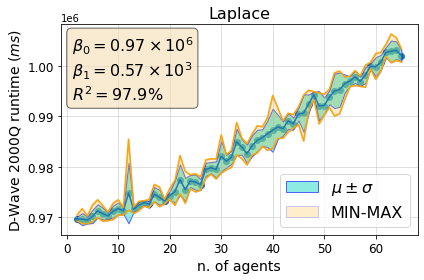

c:\users\anma10\pycharmprojects\dp-q\venv\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


C:\Users\anma10\PycharmProjects\DP-Q\QA_results\123\output\total\normal.jpeg
64


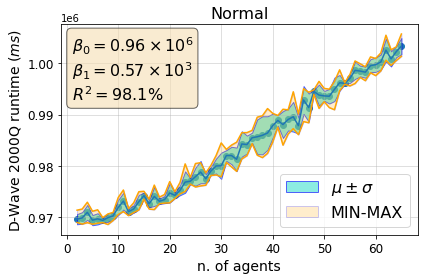

c:\users\anma10\pycharmprojects\dp-q\venv\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


C:\Users\anma10\PycharmProjects\DP-Q\QA_results\123\output\total\uniform.jpeg
64


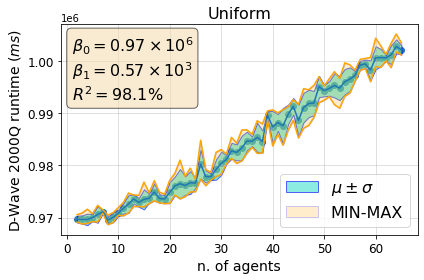

In [66]:
plot_and_save(full_df, variable, seed, folder_out, rescaling=1, figsize = (6,4))

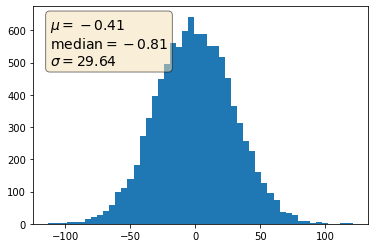

In [10]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(19680801)

fig, ax = plt.subplots()
x = 30*np.random.randn(10000)
mu = x.mean()
median = np.median(x)
sigma = x.std()
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))

ax.hist(x, 50)
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.show()

In [11]:
# df = mean.join(std)
# df = df.join(maximum)
# df = df.join(minimum)

# df.head()

In [12]:
# df = df/10**6
# df = df.reset_index()
# df.head()

In [13]:
# df["upper"] = df.qpu_sampling_time_mean + df.qpu_sampling_time_std
# df["lower"] = df.qpu_sampling_time_mean - df.qpu_sampling_time_std

In [14]:
# for distr in df.distribution.unique():
#     data = df.loc[df.distribution == distr, ]
#     data['n'] =data['n'].astype(int)
#     data = data.sort_values(by="n")
#     plt.figure(figsize=(10,6))

#     plt.plot(data['n'], data['qpu_sampling_time_mean'])  
#     plt.scatter(data['n'], data['qpu_sampling_time_mean'])

#     plt.fill_between(data['n'], data["lower"], data["upper"], color = 'turquoise',alpha = 0.6, edgecolor="b", label="std")
#     plt.fill_between(data['n'], data["qpu_sampling_time_min"], data["qpu_sampling_time_max"], color = 'orange',alpha = 0.2, edgecolor="b", label="min_max")

#     plt.title(distr)
#     plt.autoscale(enable=True)
#     plt.grid()
#     plt.legend()
# #     plt.show()